## **3. Identificación de la serie de tiempo**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz
from pathlib import Path

In [2]:
ROOT = Path.cwd().resolve().parent
DATA = ROOT / "Data" / "train.csv"

In [3]:
df_train = pd.read_csv(DATA)

Ahora procederemos a determinar si la serie es estacionaria (débil o fuerte) o no lo es. Los pasos a realizar son los siguientes:

1.  **Análisis Gráfico:** Realizar la gráfica de la serie original.

2.  **Prueba de Estacionariedad:** Determinar si la serie es estacionaria por medio del **Test de Dickey–Fuller**.

3.  **Diferenciación:** En caso de que la prueba indique que **no** es estacionaria, diferenciar la serie.

4.  **Verificación:** Realizar la gráfica de la serie diferenciada y regresar al paso 1. En caso de que ya sea estacionaria, continuar con el paso 5.

5.  **Identificación:** Estimar los órdenes **p** y **q** utilizando:
    * FAS (Función de Autocorrelación Simple - ACF)
    * FAP (Función de Autocorrelación Parcial - PACF)

### Como primer paso realizaremos la gráfica de la serie

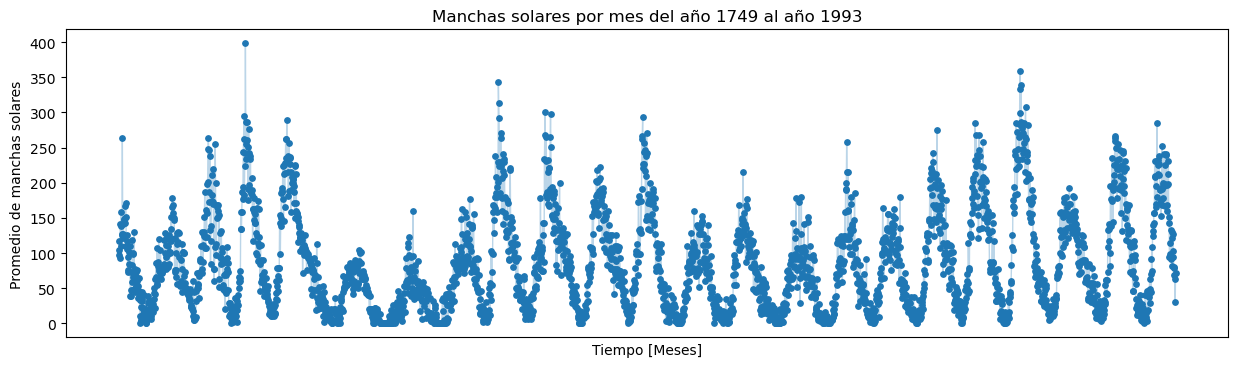

In [4]:
plt.figure(figsize=(15,4))
plt.plot(df_train['Date'], df_train['Monthly Mean Total Sunspot Number'],
         linestyle='-', alpha=0.3, linewidth=1)
plt.scatter(df_train['Date'], df_train['Monthly Mean Total Sunspot Number'],
            s=15)
plt.xticks([])
plt.title('Manchas solares por mes del año 1749 al año 1993')
plt.xlabel('Tiempo [Meses]')
plt.ylabel('Promedio de manchas solares')
plt.show()

### b) Determinar estacionariedad por medio de:
1. Test de Dickey–Fuller.

#### Test de Dickey-Fuller Aumentado

In [5]:
from statsmodels.tsa.stattools import adfuller # ya es el aumentado
def test_Dickey_Fuller(df, valor):
    resultado = adfuller(df[valor])

    print("estadístico de prueba ADF:", resultado[0])
    print("p-valor:", resultado[1])
    print("Valores críticos:")
    for key, value in resultado[4].items():
        print(f" {key}: {value}")

Tenemos que para el modelo más simple
$$z_t = c + \phi z_{t-1} + a_t$$ 

Donde $\{a_t\}$ es un proceso de ruido blanco con varianza $\sigma^2$,  la condición necesaria para que el proceso sea estacionario es que $|\phi| < 1$.

Si realizamos la resta con $z_{t-1}$ para ver la diferencia tenemos: 

$$z_t - z_{t-1} = c + \phi z_{t-1} -z_{t-1} + a_t$$
$$\nabla z_t = c + \beta z_{t-1} + a_t$$

Con $\beta =  \phi-1$

Si $\beta = 0$ Entonces $\phi = 1$ lo cual rompe con la condición de estacionariedad anteriormente mencionada

Si $\beta < 0 $ Entonces $\phi <1$ lo que cumple con la condición de estacionariedad

La prueba se puede generalizar para p retardos anteriores y es la que se aplica en nuestra prueba de hipótesis.

Es por eso que el juego de hipótesis es:

$$H_0: \beta = 0 \text{  No estacionaria} $$ 
$$vs$$
$$H_a: \beta < 0 \text{  Estacionaria}$$ 

Es decir, que si $β = 0$ entonces la serie tendrá una raíz unitaria que implica
que la serie no es estacionaria, por el contrario, si $β < 0$ entonces la serie no
tiene raíces unitarias y por lo tanto, la serie es estacionaria.

In [6]:
test_Dickey_Fuller(df_train, 'Monthly Mean Total Sunspot Number')

estadístico de prueba ADF: -10.030611252162272
p-valor: 1.588700853909196e-17
Valores críticos:
 1%: -3.432599941476293
 5%: -2.8625340736385594
 10%: -2.5672991734698956


Como podemos observar nuestro estadistico de prueba es mucho menor que el valor crítico para el intervalo de confianza de 1% por lo que podemos rechazar la hipótesis nula, es decir, nuestra serie es estacionaria, por lo que no debemos de derivarla.

### c) En caso de no ser estacionaria, diferenciar.

Si nuestra serie, en la prueba de hipótesis hubiera salido no estacionaria, entonces el siguiente paso a realizar es la diferienciación.

La cuál es aplicar diferencias sucesivas a los valores de la serie original con el objetivo de eliminar la tendencia y estabilizar la media, transformando así un proceso no estacionario en uno estacionario.

Teóricamente, la primera diferencia se obtiene restando al valor actual $z_t$ su valor inmediatamente anterior $z_{t-1}$. Utilizando la notación del operador de retardo $B$ (donde $B z_t = z_{t-1}$), la diferencia de orden uno se define como:

$$\nabla z_t = z_t - z_{t-1} = (1 - B)z_t$$

Si tras esta transformación la serie aún no es estacionaria en media, se deben tomar diferencias de orden superior. En general, si una serie $\{Z_t\}$ es un proceso integrado de orden $d$ (denotado como $Z_t \sim I(d)$), significa que debe diferenciarse $d$ veces para convertirse en un proceso estacionario invertible $ARMA(p,q)$.

La serie diferenciada de orden $d$, que llamaremos $\{Y_t\}$, se expresa teóricamente como:

$$Y_t = \nabla^d z_t = (1 - B)^d z_t$$

Esta transformación genera una nueva serie $\{Y_t\}$ cuya longitud efectiva será $T^* = T - d$, la cual preserva el orden de los elementos pero disminuye su dispersión, permitiendo proceder a la etapa de identificación de los órdenes $p$ y $q$.

La función para diferenciar una vez la serie es la siguiente:

In [7]:
def diferenciar(df, valor):
    df2 = df.copy()
    df2['z_t-1'] = df2[valor].shift(1)
    df2['nabla z'] = df2[valor] - df2['z_t-1']
    df_z = df2['nabla z'].dropna() 
    return df_z

### Una vez tenemos una serie estacionaria el siguiente paso es identificar el órden de los parámetros **p** y **q** mediante:

1. FAS (Función de Autocorrelación Simple - ACF)
2. FAP (Función de Autocorrelación Parcial - PACF)

El FAS y FAP lo que hacen es medir la dependencia estadística entre las observaciones de la serie en diferentes momentos del tiempo.

### Para FAS (Función de Autocorrelación Simple):

La Función de Autocorrelación Simple describe el grado de dependencia lineal entre la variable en el instante $t$ ($z_{t}$) y su valor en el pasado $z_{t-k}$, es decir, mide la correlación entre observaciones separadas por $k$ retardos.

Teóricamente, esta función se obtiene dividiendo la autocovarianza de orden $k$ ($\gamma_{k}$) entre la varianza del proceso ($\gamma_{0}$):

$$\rho_{k} = \frac{\gamma_{k}}{\gamma_{0}}$$

Donde sus valores se encuentran acotados entre -1 y 1.

Si nuestra serie tiene longitud $T$, entonces el cálculo de los coeficientes de autocorrelación muestral está dada por la forma:

$$\hat{\rho}_k = \frac{\sum^{T^*}_{t=k+1}(y_t - \bar{\mu})(y_{t-k}-\bar{\mu}) }{\sum^{T^*}_{t=k+1}(y_t - \bar{\mu})^2} \qquad k=1,2,...,T^*-1$$

Donde $T^* = T-d$, siendo $d$ el número de veces que tuvimos que diferenciar nuestra serie para volverla estacionaria.

### Para FAP (Función de Autocorrelación Parcial):

Se define el coeficiente de autocorrelación parcial de orden $k$, denotado como $\rho_{k}^{p}$, como el coeficiente de correlación entre observaciones separadas $k$ periodos cuando se elimina la relación lineal dependiente de los términos intermedios.

Para calcular $\rho_{k}^{p}$ se debe eliminar el efecto de los retardos intermedios $(\tilde{z}_{t-1}, \tilde{z}_{t-2}, ..., \tilde{z}_{t-k+1})$ sobre la variable ajustada $\tilde{z}_{t}$ (donde $\tilde{z}_{t} = z_{t} - \mu$).

**Recordemos que para un $AR(p)$:**

Una serie de tiempo $\{Z_{t}\}$ estacionaria sigue un proceso autorregresivo de orden $p$ si $z_{t}$ se puede expresar en términos de sus retardos hasta $z_{t-p}$ y una innovación $a_{t}$, es decir:

$$z_{t} = \phi_{1} z_{t-1} + \cdot\cdot\cdot + \phi_{p} z_{t-p} + a_{t}$$

Nosotros queremos encontrar los coeficientes que describen la dependencia.

Para obtener la función de autocorrelación simple (fas) y relacionarla con estos coeficientes, multiplicamos la ecuación del proceso por $z_{t-k}$, tomamos esperanzas matemáticas y dividimos por la varianza $\gamma_{0}$, obteniendo la relación:

$$\rho_{k} = \phi_{1} \rho_{k-1} + \phi_{2} \rho_{k-2} + \cdot\cdot\cdot + \phi_{p} \rho_{k-p}$$

Para hallar la función de autocorrelación parcial, ajustamos regresiones sucesivas para cada orden $k$. El coeficiente de autocorrelación parcial de orden $k$ es el último coeficiente ($\alpha_{kk}$) al ajustar los datos a un proceso autorregresivo de orden $k$:

$$\tilde{z}_{t} = \alpha_{k1}\tilde{z}_{t-1} + \cdot\cdot\cdot + \alpha_{kk}\tilde{z}_{t-k} + \eta_{t}$$

Esto implica resolver el sistema de ecuaciones para cada $k$, donde $\rho_{k}^{p} = \alpha_{kk}$:

1.  **Para $k=1$ (Ajuste $AR(1)$):**
    $$\rho_{1} = \alpha_{11} \rho_{0} \implies \rho_{1} = \alpha_{11} (1)$$
    Por lo tanto: $\rho_{1}^{p} = \alpha_{11} = \rho_{1}$.

2.  **Para $k=2$ (Ajuste $AR(2)$):**
    $$\rho_{1} = \alpha_{21} \rho_{0} + \alpha_{22} \rho_{1}$$
    $$\rho_{2} = \alpha_{21} \rho_{1} + \alpha_{22} \rho_{0}$$
    Resolviendo este sistema para $\alpha_{22}$, obtenemos el valor de la FAP en el retardo 2 ($\rho_{2}^{p}$).

3.  **Para el caso general $k$:**
    $$\rho_{j} = \alpha_{k1} \rho_{j-1} + \cdot\cdot\cdot + \alpha_{kk} \rho_{j-k}, \quad j=1,...,k$$
    
    El valor $\alpha_{kk}$ obtenido al resolver este sistema es la autocorrelación parcial $\rho_{k}^{p}$.

In [8]:
def FAS(df, valor,d):
    serie = df[valor]
    media = serie.mean()
    centrada = serie - media
    
    T = len(serie)
    error_estandar = 1 / np.sqrt(T)
    p_k = []

    p_k = []

    for k in range(T-1):
        y_t_k = centrada.shift(k)
        numerador = (centrada * y_t_k).sum()
        mask_validos = ~y_t_k.isna() 
        denominador = (centrada[mask_validos] ** 2).sum()

        if denominador == 0:
            p_k.append(0)
        else:
            p_k.append(float(numerador / denominador))

    return p_k, error_estandar

In [9]:
def FAP(p_k):
    """ Queremos resolver el sistema
    B = A@phi
    Donde B = [rho_1, ..., rho_k]
    A = Es una matriz de toeplitz con base rho_1,...,rho_k
    """
    p_k = np.array(p_k)
    T = len(p_k)
    alphas = [1.0] # La FAP en lag 0 es 1.0
    
    for k in range(1, T):
        B = p_k[1:k+1]
        columna_base = p_k[:k] 
        A = toeplitz(columna_base)
    
        try:
            phi = np.linalg.solve(A, B)
            # El último elemento de phi es la FAP (alpha_kk)
            alphas.append(float(phi[-1]))
        except np.linalg.LinAlgError:
            alphas.append(0) # si la matriz es singular
            
    return alphas

### 1. Construcción de Bandas de Confianza

Para identificar cuando un coeficiente es distinto de cero se necesita conocer su error estándar. Se toma $\frac{1}{\sqrt{T^{*}}}$ como la aproximación del error.

A partir de este valor se construyen bandas de confianza de $\pm \frac{2}{\sqrt{T^{*}}}$. Se consideran como significativos únicamente a los coeficientes que se encuentran fuera de dichas bandas.

### 2. Reglas de Identificación

Para determinar el orden de la parte autorregresiva ($p$) y de medias móviles ($q$), se analiza el comportamiento de la Función de Autocorrelación Simple (fas) y la Función de Autocorrelación Parcial (fap):

**Proceso Autorregresivo $AR(p)$**
* **Comportamiento fas:** Decrece geométricamente.
* **Comportamiento fap:** Las primeras $p$ observaciones son diferentes de cero, y a partir de la observación $p+1$ el valor es cero.
* **Identificación:** Se utiliza la **fap** para identificar el orden del proceso.

**Proceso de Medias Móviles $MA(q)$**
* **Comportamiento fas:** Decae a cero a partir de la observación $q+1$.
* **Comportamiento fap:** Presenta un decaimiento geométrico.
* **Identificación:** Se utiliza la **fas** para identificar el orden del proceso.

In [10]:
p_k, error_estandar = FAS(df_train, 'Monthly Mean Total Sunspot Number',0)

In [11]:
Lags_a_mostrar = 60

p_k_recortado = p_k[:Lags_a_mostrar]
alphas = FAP(p_k_recortado)

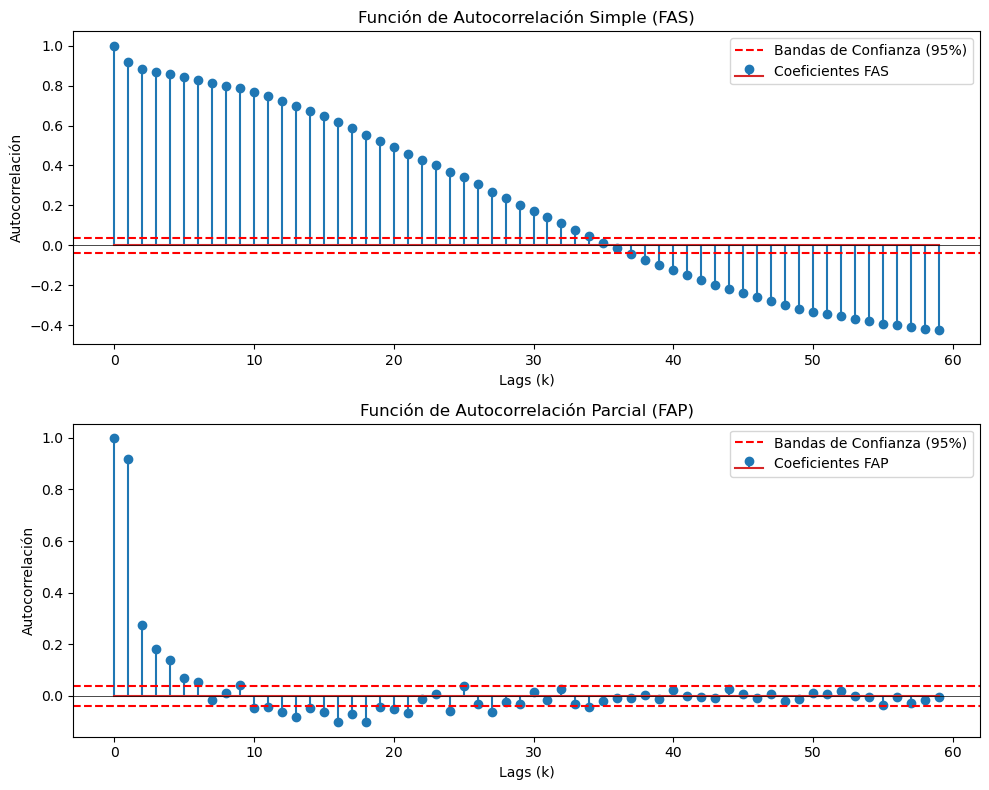

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# FAS
lags_fas = range(len(p_k_recortado))
ax1.stem(lags_fas, p_k_recortado, label='Coeficientes FAS')
ax1.axhline(y=-2 * error_estandar, color='red', linestyle='--', label='Bandas de Confianza (95%)')
ax1.axhline(y=2 * error_estandar, color='red', linestyle='--')
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.set_title("Función de Autocorrelación Simple (FAS)")
ax1.set_xlabel("Lags (k)")
ax1.set_ylabel("Autocorrelación")
ax1.legend(loc='best')

# FAP
lags_fap = range(len(alphas))
ax2.stem(lags_fap, alphas, label='Coeficientes FAP')
ax2.axhline(y=-2 * error_estandar, color='red', linestyle='--', label='Bandas de Confianza (95%)')
ax2.axhline(y=2 * error_estandar, color='red', linestyle='--')
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_title("Función de Autocorrelación Parcial (FAP)")
ax2.set_xlabel("Lags (k)")
ax2.set_ylabel("Autocorrelación")
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

### Análisis de la Función de Autocorrelación Simple (FAS)

**Observaciones Visuales:**
* La gráfica muestra una correlación que comienza en 1.0 y desciende de manera muy gradual posiblemente geométricamente para antes del lag 35 pero sin que los demás valores sean cero.

* No se observa que la función caiga a cero súbitamente después de un lag específico.

* Se descarta un proceso de Medias Móviles puro ($MA(q)$), ya que este debería mostrar un corte abrupto después de unos pocos lags.

### Análisis de la Función de Autocorrelación Parcial (FAP)

**Observaciones Visuales:**
* A diferencia de la fas, la fap muestra valores altos al principio que luego caen hacia cero.
* **Lag 1:** Muestra una correlación muy alta (cercana a 0.9), claramente significativa.
* **Lag 2:** Es positivo y significativo (notablemente fuera de las bandas rojas), con un valor aproximado de 0.3.
* **Lag 3:** Continúa siendo significativo y positivo (aprox 0.2).
* **Lag 4:** Se mantiene apenas fuera de la banda de confianza superior, indicando significancia estadística leve.
* **Lags Posteriores ($k \ge 5$):** A partir del lag 5, la mayoría de los coeficientes entran dentro de las bandas de confianza (ruido blanco), aunque se observan algunas oscilaciones menores posteriores.

* La estructura de la fap permite identificar el orden $p$ del proceso autorregresivo.
* Dado que los coeficientes son significativos hasta el lag 3 o 4 y luego se "cortan" (entran en la banda), el orden $p$ sugerido se encuentra en ese rango.

### Propuesta de Modelos Candidatos

Basado en las gráficas, se proponen los siguientes modelos para la etapa de estimación:

1.  **Modelo AR(2) - $ARIMA(2,0,0)$:**
    * **Justificación:** Aunque el lag 3 es significativo, el lag 1 y 2 capturan la mayor parte de la estructura de dependencia directa.

2.  **Modelo AR(3) - $ARIMA(3,0,0)$:**
    * **Justificación:** Dado que la barra del lag 3 en la fap es claramente visible fuera de las bandas de confianza, este modelo podría ser necesario para eliminar la autocorrelación restante en los residuos.

3.  **Modelo AR(4) - $ARIMA(4,0,0)$:**
    * **Justificación:** Se propone como un límite superior, dado que el lag 4 está en el borde de la significancia. Se deberá verificar si este coeficiente aporta valor real o si sobreajusta el modelo.

4.  **Modelo ARMA(2,1) - $ARIMA(2,0,1)$:**
    * **Justificación:** Debido a que la fas decae muy lentamente, a veces un componente de media móvil ($q=1$) combinado con la parte autorregresiva ayuda a limpiar la estructura de dependencia sin necesitar tantos términos AR.